# 链接仪器

In [22]:
from qulab.sugar import connect
from qulab.job import Job
from qulab.storage.utils import save
import matplotlib.pyplot as plt
import numpy as np, imp
from qulab.math import opt
from collections import namedtuple, deque, defaultdict, OrderedDict, Counter
from scipy.optimize import curve_fit, least_squares as ls
import time, asyncio, sys
from tqdm import tqdm_notebook as tqdm
from qulab.wavepoint import WAVE_FORM as WF
from qulab import optimize, measureroutine, computewave
from qulab.optimize import Collect_Waveform 
from qulab.waveform import CosPulseDrag, Expi, DC, Step, Gaussian
from qulab.math.qst import transformList, acquireVFromData, vToRho
op = imp.reload(optimize)
mr = imp.reload(measureroutine)
cw = imp.reload(computewave)

In [2]:
ats18 = await connect('ATS18')
psg101 = await connect('PSG101')
psg104 = await connect('PSG104')
psg106 = await connect('PSG106')
dc03 = await connect('DC03')

In [3]:
psg_lo = psg104
psg_pump = psg101
psg_ex = psg106
ats = ats18

In [8]:
await dc03.setValue('Load','High')

# 测背底

In [4]:
async def S21(freq):
    await psg_lo.setValue('Output','ON')
    for i in freq:
        await psg_lo.setValue('Frequency', i)
        ch_A, ch_B = await ats.getIQ(hilbert=False,offset=True)
        Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
        theta0 = np.angle(Am) - np.angle(Bm)
        Bm *= np.exp(1j*theta0)
        s = Am + Bm
        yield [i-50e6], s

In [5]:
freq = np.linspace(-300,400,701)*1e6 + 6.3e9 + 50e6
tag = 'jpa'
await dc03.DC(0)
await psg_pump.setValue('Output','OFF')
job = Job(S21, (freq,), tags=[tag], max=len(freq))
f, base = await job.done()

Output()

<IPython.core.display.Javascript object>


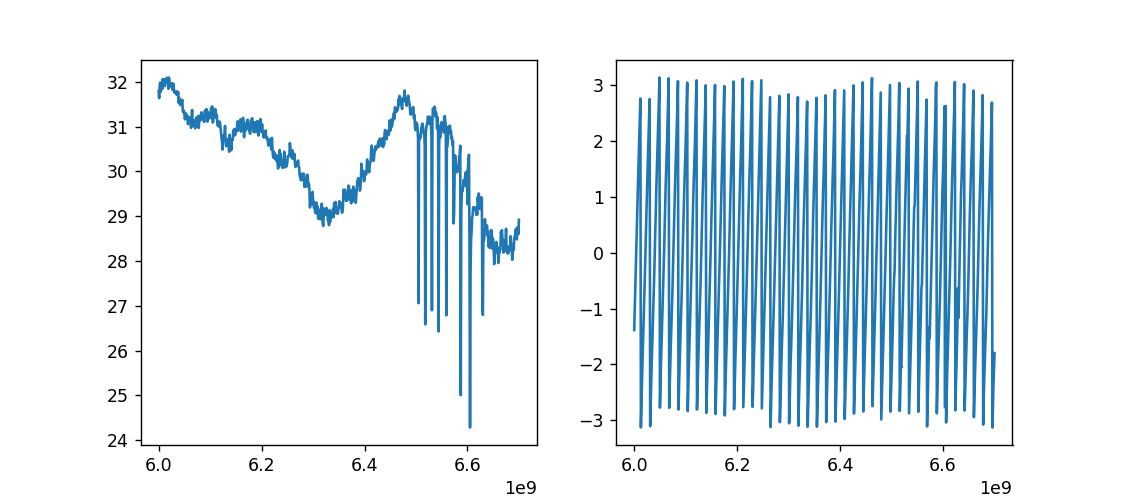

In [16]:
%matplotlib notebook
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f[:,0],20*np.log10(np.abs(base[:,0])))
axes[1].plot(f[:,0],np.angle(base[:,0]))
plt.show()

In [29]:
f_cavity = np.array([6.505,6.518,6.531,6.544,6.559,6.573,6.587,6.600,6.605,6.630])*1e9 + 50e6

In [31]:
20*np.log10(np.abs(base_sn))

array([[26.84456079],
       [26.44386009],
       [26.61031868],
       [26.51023936],
       [26.51342281],
       [28.82554453],
       [25.21544999],
       [29.50960991],
       [23.75851686],
       [26.53286174]])

# S21vsFlux

In [33]:
async def S21vsFlux(freq,current):
    await psg_ex.setValue('Output','OFF')
    await psg_pump.setValue('Output','OFF')
    await psg_lo.setValue('Output','ON')
    for i in current:
        await dc03.DC(i)
        job = Job(S21, (freq,),auto_save=False, no_bar=True, tags=['test'], max=len(freq))
        f_s21, s_s21 = await job.done()
        yield [i]*1, f_s21, s_s21

In [34]:
#freq = np.linspace(-500,500,1001)*1e6 + 6.3e9
current = np.linspace(-1,1,21)
job = Job(S21vsFlux, (freq,current), tags=[tag], max=len(current))
volt, f_bias, s_bias = await job.done()

Output()

In [35]:
await dc03.DC(0)

## 扣除相位

<IPython.core.display.Javascript object>


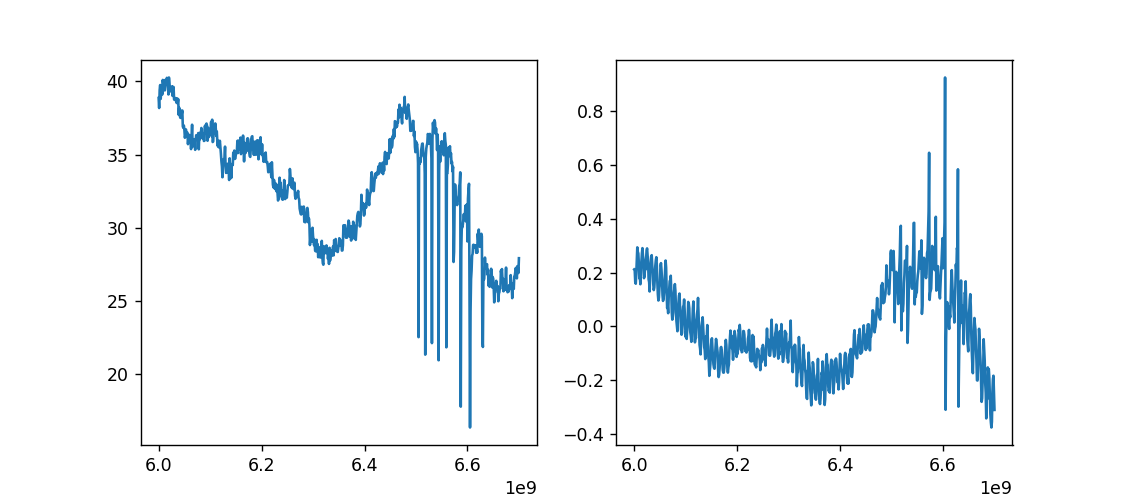

In [9]:
phi = np.unwrap(np.angle(base[:,0]), 0.9 * np.pi)
phase = np.poly1d(np.polyfit(f[:,0], phi, 1))
s21_base = base[:,0] / np.exp(1j * phase(f[:,0]))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f[:,0],np.abs(s21_base))
axes[1].plot(f[:,0],np.angle(s21_base))
plt.show()

In [17]:
s21 = []
for i in s_bias[:,:,0]:
    phi = np.unwrap(np.angle(i), 0.9 * np.pi)
    phase = np.poly1d(np.polyfit(f[:,0], phi, 1))
    sm = i / np.exp(1j * phase(f[:,0]))
    s21.append(sm)
s21 = np.array(s21)

## 扣除背底

<IPython.core.display.Javascript object>


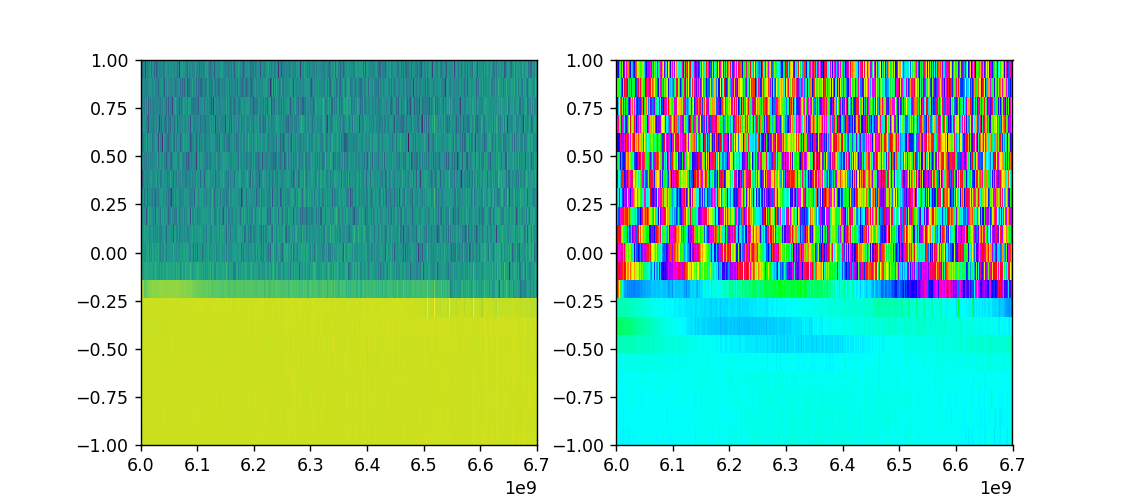

In [18]:
%matplotlib notebook
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(f_bias),np.max(f_bias),np.min(volt),np.max(volt)]
axes[0].imshow(20*np.log10(np.abs(s21/s21_base)),extent=extent,aspect='auto',origin='lower')
axes[1].imshow(np.angle(s21/s21_base),extent=extent,aspect='auto',origin='lower',cmap='hsv')
plt.show()

# BiasvsPump

In [10]:
await psg_pump.setValue('Output','OFF')
await psg_lo.setValue('Frequency',(6.3e9+50e6))
await dc03.DC(0)
ch_A, ch_B = await ats.getIQ(hilbert=False,offset=True)
Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
theta0 = np.angle(Am) - np.angle(Bm)
Bm *= np.exp(1j*theta0)
base_single = Am + Bm

In [11]:
async def SingleBias(bias):
    await psg_lo.setValue('Output','ON')
    await psg_lo.setValue('Frequency',(6.3e9+50e6))
    for i in bias:
        await dc03.DC(i)
        ch_A, ch_B = await ats.getIQ(hilbert=False,offset=True)
        Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
        theta0 = np.angle(Am) - np.angle(Bm)
        Bm *= np.exp(1j*theta0)
        s = Am + Bm
        yield [i], s 

In [12]:
async def BiasvsPump(bias,pump):
    await psg_ex.setValue('Output','OFF')
    await psg_pump.setValue('Output','ON')
    await psg_pump.setValue('Frequncy',(2*(6.3e9)+2e6))
    for i in pump:
        await psg_pump.setValue('Power',i)
        job = Job(SingleBias, (bias,),auto_save=False, no_bar=True, tags=['test'], max=len(bias))
        v_sb, s_sb = await job.done()
        yield [i]*1, v_sb, s_sb

In [13]:
power = np.linspace(-6,0,31)
current = np.linspace(-1,1,51)
job = Job(BiasvsPump, (current,power), tags=[tag], max=len(power))
p_pump, v_pump, s_pump = await job.done()

Output()

<IPython.core.display.Javascript object>


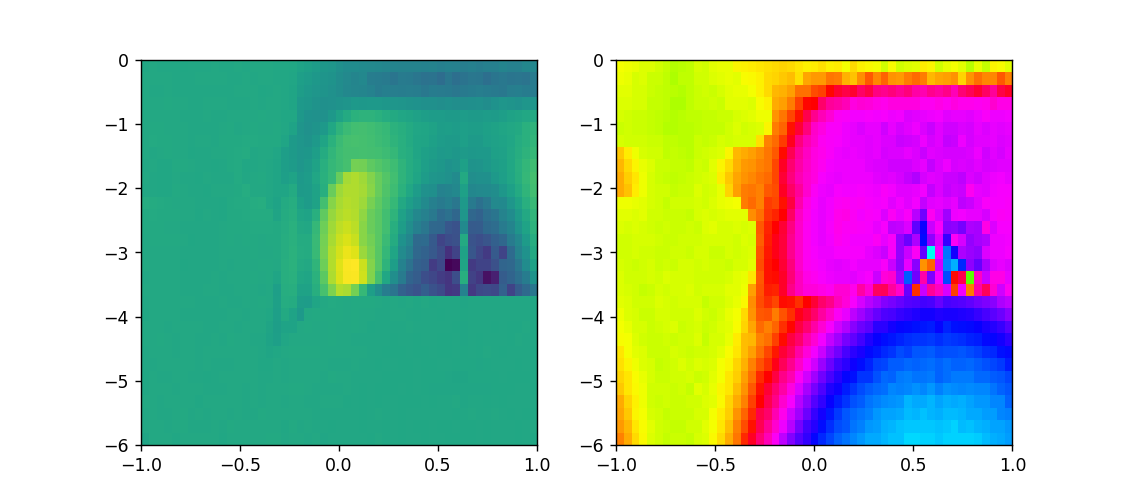

In [14]:
s = (s_pump[:,:,0] / base_single) #检查shape
%matplotlib notebook
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(v_pump),np.max(v_pump),np.min(p_pump),np.max(p_pump)]
axes[0].imshow(20*np.log10(np.abs(s)),extent=extent,aspect='auto',origin='lower')
axes[1].imshow(np.angle(s),extent=extent,aspect='auto',origin='lower',cmap='hsv')
plt.show()

In [15]:
index = np.argmax(np.abs(s))
c_op, p_op = current[index%len(current)],power[index//len(current)]
print('current=%f, power=%f'%(c_op,p_op))

current=0.080000, power=-3.200000


## 单条检测

Output()

<IPython.core.display.Javascript object>


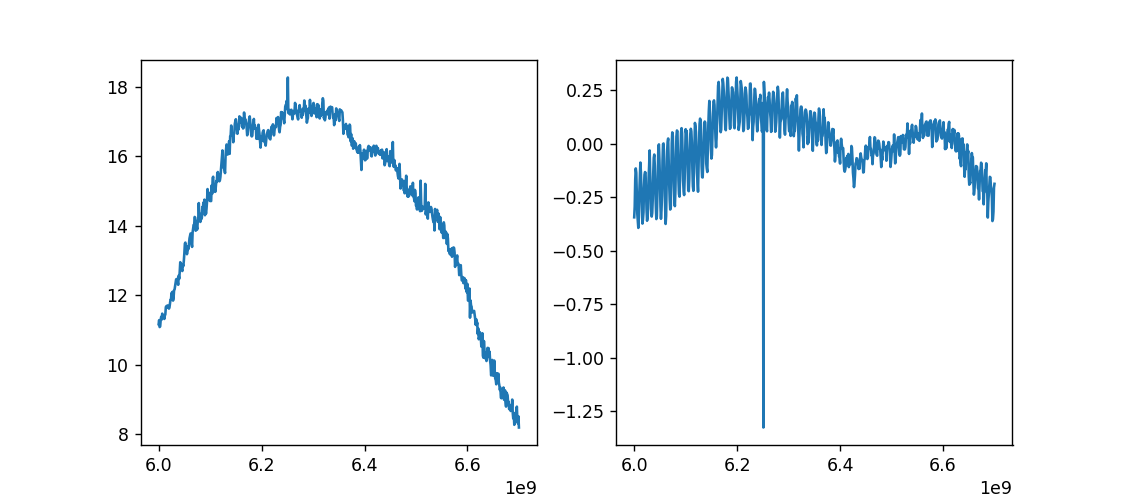

In [34]:
await dc03.DC(0.058)
await psg_pump.setValue('Power',-1.789)
await psg_pump.setValue('Output','ON')
job = Job(S21, (freq,), tags=[tag], max=len(freq))
f_tests, s_tests = await job.done()
f_tests, s_tests = op.RowToRipe().deductPhase(f_tests[:,0],s_tests[:,0])
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_tests,20*np.log10(np.abs(s_tests[0]/s21_base)))
axes[1].plot(f_tests,np.angle(s_tests[0]/s21_base))
plt.show()

## 单纯形法

In [35]:
tag = 'jpa'
await dc03.DC(0)
await psg_pump.setValue('Output','OFF')
job = Job(S21, (f_cavity,), tags=[tag], max=len(f_cavity))
f_sn, base_sn = await job.done()

Output()

In [36]:
async def Gain(bias,power):
    global f_cavity
    await dc03.DC(bias)
    await psg101.setValue('Power',power)
    job = Job(S21, (f_cavity,), tags=[tag], max=len(f_cavity),no_bar=True)
    f_tests, s_tests = await job.done()
    index = np.abs(s_tests/base_sn).argmin()
    return -20*np.log10(np.abs(s_tests[index]/base_sn[index]))

In [37]:
await psg_pump.setValue('Output','ON')
opt.optimize(Gain,[c_op,p_op],[0.001,0.05],[3,3],print_info=True)

Output()

.o
[ 0.08 -3.2 ] [-4.99917224]   

Output()

.

Output()

.o
[ 0.08 -3.15] [-5.54375291]   

Output()

.

Output()

.o
[ 0.079 -3.1  ] [-5.91333146]   

Output()

.o
[ 0.079 -3.05 ] [-6.42209368]   

Output()

.

Output()

.o
[ 0.078 -2.95 ] [-6.78537776]   

Output()

.o
[ 0.077 -2.85 ] [-7.23195665]   

Output()

.

Output()

.o
[ 0.075 -2.65 ] [-7.48733268]   

Output()

.o
[ 0.073 -2.45 ] [-7.90151532]   

Output()

.o
[ 0.074 -2.45 ] [-7.97344211]   

Output()

.o
[ 0.072 -2.25 ] [-8.11894866]   

Output()

.o
[ 0.068 -1.85 ] [-9.78161613]   

Output()

.

Output()

.

Output()

.

Output()

.

Output()

.

Output()

.o
[ 0.068 -1.787] [-10.1217759]   

Output()

.

Output()

.

Output()

.o
[ 0.067 -1.728] [-10.1692377]   .

Output()

.

Output()

.

Output()

.

Output()

.

Output()

.

Output()

.o
[ 0.067 -1.738] [-10.22507008]   

Output()

.

Output()

.o
[ 0.067 -1.757] [-10.23667638]   

Output()

.o
[ 0.067 -1.767] [-10.32828561]   

Output()

.

Output()

.

Output()

.

Output()

.

Output()

..

Output()

..

Output()

.....

Output()

..

Output()

..

Output()

..

Output()

...............
 CacheInfo(hits=24, misses=44, maxsize=128, currsize=44)


 final_simplex: (array([[ 0.06714896, -1.76682129],
       [ 0.0671477 , -1.76682277],
       [ 0.06714961, -1.7668965 ]]), array([-10.32828561, -10.32828561, -10.32828561]))
           fun: -10.32828560519877
       message: 'Optimization terminated successfully.'
          nfev: 68
           nit: 29
        status: 0
       success: True
             x: array([ 0.067, -1.767])

## 多条检测

In [18]:
async def SingleS21(current,freq):
    for i in current:
        await dc03.DC(i)
        job = Job(S21, (freq,), tags=[tag],no_bar = True, max=len(freq))
        f_test, s_test = await job.done()
        yield [i], f_test, s_test

In [21]:
current = np.linspace(-0.04,0.08,61)
await psg_pump.setValue('Power',-5)
await psg_pump.setValue('Output','ON')
await psg_lo.setValue('Output','ON')
job = Job(SingleS21, (current,freq), tags=[tag], max=len(current))
v_test, f_test, s_test = await job.done()

Output()

In [22]:
await dc03.DC(0)
await psg_pump.setValue('Output','OFF')

<IPython.core.display.Javascript object>


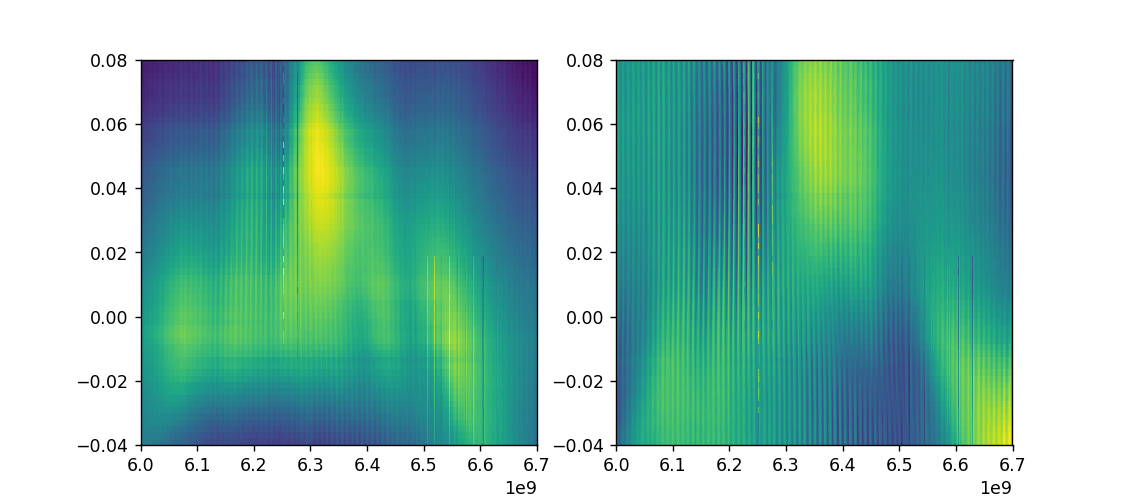

In [24]:
f_testn, s_testn = op.RowToRipe().deductPhase(f_test[:,:,0][0],s_test[:,:,0])

fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(f_testn),np.max(f_testn),np.min(v_test),np.max(v_test)]
axes[0].imshow(20*np.log10(np.abs(s_testn/s21_base)),extent=extent,origin='lower',aspect='auto')
axes[1].imshow(np.angle(s_testn/s21_base),extent=extent,origin='lower',aspect='auto')
plt.show()

In [414]:
fig, axes = plt.subplots(ncols=2,nrows=(len(current)//2+len(current)%2),figsize=(9,2*(len(current)//2+len(current)%2)))
for j, i in enumerate(s_test):
    axes[j//2][j%2].plot(f_test,20*np.log10(np.abs(i/s21_base)))
    axes[j//2][j%2].settitle('%d'%j)
    #axes[j//2][1].plot(f_test,np.angle(i/s21_base))
plt.show()

# S21vsPump

In [400]:
async def S21vsPump(freq,pump):
    await psg_ex.setValue('Output','OFF')
    await psg_pump.setValue('Output','ON')
    await psg_lo.setValue('Output','ON')
    for i in pump:
        await psg_pump.setValue('Power',i)
        job = Job(S21, (freq,),auto_save=False, no_bar=True, tags=['test'], max=len(freq))
        f_s21, s_s21 = await job.done()
        yield [i]*1, f_s21, s_s21

In [401]:
power = np.linspace(-0.5,0.5,21) + p_op
await dc03.DC(-0.012)
job = Job(S21vsPump, (freq,power), tags=[tag], max=len(power))
p_p, f_p, s_p = await job.done()

Output()

In [404]:
f_pn, s21_pump = op.RowToRipe().deductPhase(f_p[:,:,0][0],s_p[:,:,0])

<IPython.core.display.Javascript object>


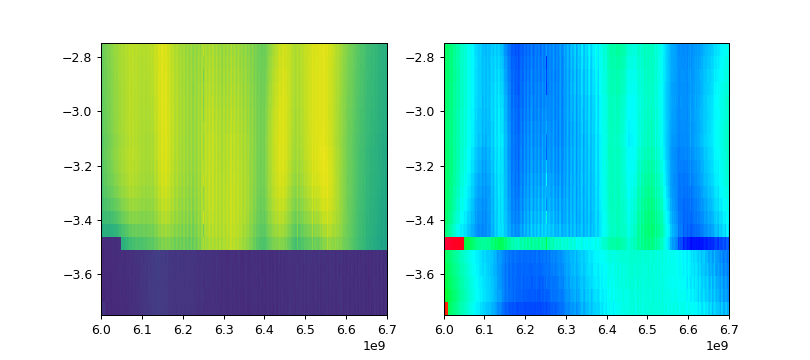

In [405]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(f_pn),np.max(f_pn),np.min(p_p),np.max(p_p)]
axes[0].imshow(20*np.log10(np.abs(s21_pump/s21_base)),extent=extent,aspect='auto',origin='lower')
axes[1].imshow(np.angle(s21_pump/s21_base),extent=extent,aspect='auto',origin='lower',cmap='hsv')
plt.show()

In [415]:
# fig, axes = plt.subplots(ncols=2,nrows=(len(power)//2+len(power)%2),figsize=(9,2*(len(power)//2+len(power)%2)))
# for j, i in enumerate(s21_pump):
#     axes[j//2][j%2].plot(f_pn,20*np.log10(np.abs(i/s21_base)))
#     axes[j//2][j%2].set_title('%d'%j)
#     #axes[j//2][1].plot(f_test,np.angle(i/s21_base))
# plt.show()

In [416]:
power[11]

-3.2

# 噪声

In [ ]:
Tp = (Y - 1) / Gp / Gi**2 / Ga * Th  #Th=4K, Ga线的衰减， Gi环形器的插入损耗， Gp：JPA增益

In [480]:
async def NoiseFreq(freq):
    for j, i in enumerate(freq):
        await psg_lo.setValue('Frequency',i)
        #JPA打开
        await psg_pump.setValue('Output','ON')
        time.sleep(0.1)
        ch_A, ch_B = await ats.getIQ(hilbert=False,offset=True)
        theta0 = np.angle(ch_A) - np.angle(ch_B)
        ch_B *= np.exp(1j*theta0)
        s = ch_A + ch_B
        sigma_on = np.std(s)
        Gp = 20*np.log10(np.abs(s.mean(axis=0)/s21_base[j]))
        #JPA关上
        await psg_pump.setValue('Output','OFF')
        time.sleep(0.1)
        ch_A, ch_B = await ats.getIQ(hilbert=False,offste=True)
        theta0 = np.angle(ch_A) - np.angle(ch_B)
        ch_B *= np.exp(1j*theta0)
        s = ch_A + ch_B
        sigma_off = np.std(s)
        
        Y = sigma_on**2 / sigma_off**2
        Tp = (Y - 1) / Gp / Gi**2 / Ga * Th
        yield [i-50e6],Tp

In [437]:
await psg_pump.setValue('Output','OFF')
time.sleep(0.1)
ch_A, ch_B = await ats.getIQ(hilbert=False,offset=True)
theta0 = np.angle(ch_A) - np.angle(ch_B)
ch_B *= np.exp(1j*theta0)
s = ch_A + ch_B
s = 

plt.plot(np.real(s),np.imag(s),'.')
plt.show()

<IPython.core.display.Javascript object>


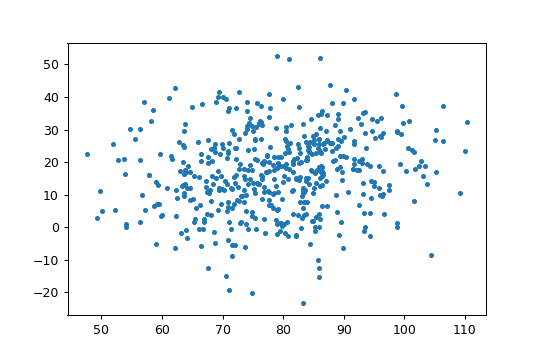

In [438]:
plt.figure()
plt.plot(np.real(s),np.imag(s),'.')
plt.show()

In [478]:
Gi, Ga, Th = -4, -5, 4
await dc03.DC(-0.012)
await psg_pump.setValue('Power',-3.2)
job = Job(NoiseFreq, (freq,), tags=[tag], max=len(freq))
f_nf, T_nf = await job.done()

Output()

<IPython.core.display.Javascript object>


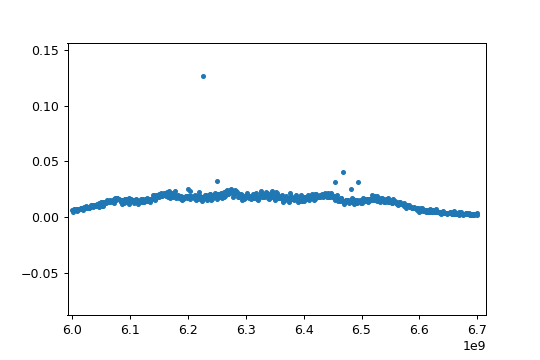

In [481]:
fig  = plt.figure()
plt.plot(f_nf,-T_nf,'.')
plt.show()

# 饱和功率

In [463]:
async def SaturationPower(signalpower,att_setup):
    for i in signalpower:
        att_setup.Att(i)
        ch_A, ch_B = await ats.getIQ(hilbert=False,offset=True)
        Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
        theta0 = np.angle(Am) - np.angle(Bm)
        Bm *= np.exp(1j*theta0)
        s = Am + Bm
        yield [i], s

In [469]:
att_setup = op.Att_Setup("COM12")
signalpower = np.linspace(0,30,61)
await dc03.DC(-0.012)
await psg_pump.setValue('Power',-3.2)
await psg_pump.setValue('Output','ON')
job = Job(SaturationPower, (signalpower,att_setup), tags=[tag], max=len(signalpower))
a_sp, s_sp = await job.done()
att_setup.close()

COM12 open...
DS Instruments,DAT64H,396,V9.10
ATT 00.0


Output()

In [475]:
freq[freq == 6064000000.0]

array([6.064e+09])

In [468]:
att_setup.close()

<IPython.core.display.Javascript object>


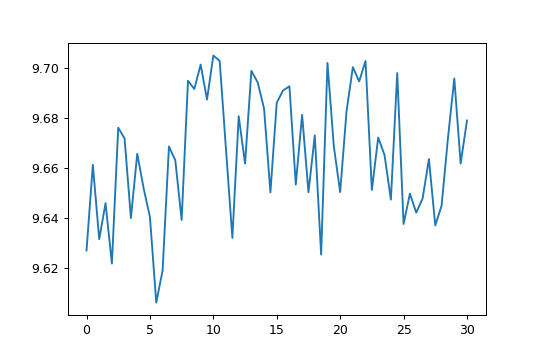

In [476]:
fig = plt.figure()
plt.plot(a_sp[:,0],20*np.log10(np.abs(s_sp[:,0]/s21_base[freq==6064000000.0])))
plt.show()